# Get Started

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Saving Remini20210418092125600.jpg to Remini20210418092125600 (1).jpg
User uploaded file "Remini20210418092125600.jpg" with length 11317 bytes
Remini20210418092125600.jpg


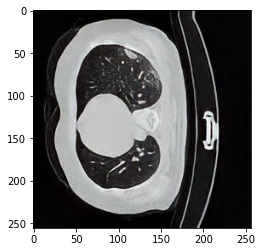

Successs
Loading saved weights...
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 1s 882ms/step
Successfully Saved Results to /content/gdrive/MyDrive/file2/file/lr-5-32-100/UNET_PREDICTIONS/


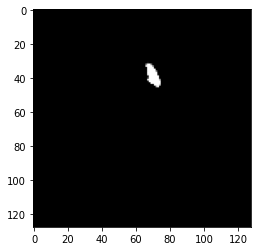

This picture is:  COVID [0.63829637 0.09199252 0.2697111 ]
0.63829637


In [ ]:
from __future__ import print_function

import numpy as np
import os
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as KTF

from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, concatenate, LeakyReLU, AveragePooling2D, Conv2D,ZeroPadding2D,Convolution2D, Conv2DTranspose,MaxPooling2D,add, UpSampling2D, multiply,Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from keras import backend as K,models
from skimage.io import imsave
import numpy as np
from PIL import Image
import os
from skimage.transform import resize
from keras.models import model_from_json
import cv2

#MODEL

def merge(inputs, mode, concat_axis=-1):
    return concatenate(inputs, concat_axis)

K.set_image_data_format('channels_last')  
smooth = 1.

img_rows =128
img_cols =128

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

data_path = '/content/gdrive/MyDrive/file/'


def unet4(upsamezhi,chuandi,F_g, F_l,F_int):
    up = Conv2D(F_g, (1, 1), activation='relu', padding='same')(upsamezhi)
    up= BatchNormalization()(up)

    down= Conv2D(F_l, (1, 1), activation='relu', padding='same')(chuandi)
    down= BatchNormalization()(down)
    
    sumadd=add([up,down])
    sumadd = Activation(activation='relu')(sumadd)
    
    
    
    jihe=Conv2D(F_int, (1, 1), activation='relu', padding='same')(sumadd)
    sumhalf= BatchNormalization()(jihe)
    
    
    sum_1=Conv2D(1, (1, 1), activation='sigmoid', padding='same')(sumhalf)
    sum_1= BatchNormalization()(sum_1)
    
    xinchuandi=multiply([chuandi,sum_1])
    return xinchuandi

def bottleneck(x, filters_bottleneck, mode='cascade', nb_layers=1,
               kernel_size=(3, 3), activation='relu'):# used in the competition
    if mode == 'cascade':
        for i in range(nb_layers):
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation, 
               padding='same', dilation_rate=1)(x)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,
               padding='same', dilation_rate=2)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=4)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=8)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=16)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=1)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=1)(x1)
            
            x = concatenate([x, x1], axis=3)
        return x

def conv_block(x, nb_filter, alpha=0.0, drop_rate=0.2):
    
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    
    if drop_rate: x = Dropout(drop_rate)(x)
    return x

def bottleneck_layer(x, nb_filter, nb_size = 4, alpha=0.0, drop_rate=0.2): #nb_size = 4,
    
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_size*nb_filter, kernel_size=(1, 1), padding='same', strides=(1, 1))(x)   #nb_size*
    
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    
    if drop_rate: x = Dropout(drop_rate)(x)
    
    return x

def Dense_Block(x, growth_rate, nb_layers=1, drop_rate=0.2):  #Dense_Block(x, nb_layers, growth_rate, drop_rate=0.2)
    
    for i in range(nb_layers):
        conv = bottleneck_layer(x, nb_filter=growth_rate, drop_rate=drop_rate)
        x = concatenate([x, conv], axis=3)
    return x

def TransitionLayer(x, compression=0.5, alpha=0.0, is_max=0):
    
    nb_filter = int(x.shape.as_list()[-1]*compression)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_filter, (1, 1), strides=(1,1), padding='same')(x)
    if is_max != 0: x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    else: x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    
    return x

def encoder(x):
    to_decoder = []
    #128*128*32    first branching to decoder
    main_path = conv_block(x, 32, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #64*64*64      second branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 64, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #32*32*128     third branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 128, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #16*16*256     fourth branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 256, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #8*8*512
    main_path = TransitionLayer(main_path, is_max=0)
    main_path = Dense_Block(main_path, 512, drop_rate=0.2)
    to_decoder.append(main_path)
    return to_decoder


def decoder(x, from_encoder):#
    #8*8*256
    main_path = UpSampling2D(size=(2, 2))(x)  
    xin_encoder_1 = unet4(main_path,from_encoder[4],256, 256,128)#
    main_path = concatenate([main_path, xin_encoder_1], axis=3)
    main_path = Dense_Block(main_path, 512, drop_rate=0.2)
    # 
    #16*16*128
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_2 = unet4(main_path,from_encoder[3],128, 128,64)
    main_path = concatenate([main_path, xin_encoder_2], axis=3)
    main_path = conv_block(main_path, 256, drop_rate=0.2)
    
    #32*32*64
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_3 = unet4(main_path,from_encoder[2],64, 64,32)
    main_path = concatenate([main_path, xin_encoder_3], axis=3)
    main_path = conv_block(main_path, 128, drop_rate=0.2)
    
    #64*64*32
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_4 = unet4(main_path,from_encoder[1],32, 32,16)
    main_path = concatenate([main_path, xin_encoder_4], axis=3)
    main_path = conv_block(main_path, 64, drop_rate=0.2)
    
    #128*128*16
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_5 = unet4(main_path,from_encoder[0],16, 16,8)
    main_path = concatenate([main_path, xin_encoder_5], axis=3)
    main_path = conv_block(main_path, 32, drop_rate=0.2)
    
    return main_path

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

#%%
#计算灵敏度  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())
#计算特异性
def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

#%%
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.只计算批处理的平均精度。

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    计算精度，一个多标签分类的度量有多少选定的项目是相关的。
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#%%
def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.仅计算批量平均召回率。

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        计算召回率，一个用于多标签分类的度量有多少相关的项目被选择。
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.只计算批处理的平均精度。

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        计算精度，一个多标签分类的度量有多少选定的项目是相关的。
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
 
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def build_res_unet( ):
    #inputs = Input(shape=input_shape)
    inputs = Input(shape=(img_rows, img_cols, 1)) 

    to_decoder = encoder(inputs)
    
    path = TransitionLayer(to_decoder[4], is_max=0)
    path = Dense_Block(path, 512, drop_rate=0.2) 
    
    bottle = bottleneck(path, filters_bottleneck=256, mode='cascade')
    
    path1 = Dense_Block(bottle, 256, drop_rate=0.2) 
    
    path = decoder(path1, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='hard_sigmoid',padding='same')(path)
    
    model=Model(inputs=inputs, outputs=path)
    

             
    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy',dice_coef, sensitivity,specificity,f1score,precision])

    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

def convert(URL):
    image_rows = 128
    image_cols = 128
    imgs = np.ndarray((1, image_rows, image_cols), dtype=np.uint8)
    i = 0
    # img = cv2.imread(URL, cv2.IMREAD_GRAYSCALE)  
    img = np.array([URL])
    imgs[i] = img
    np.save(data_path + '/covert1.npy', imgs)
    print("Successs")


data_path ='/content/gdrive/MyDrive/file2/file/'
path = '/content/gdrive/MyDrive/file2/file/lr-5-32-100/'
img_predict = r'/content/gdrive/MyDrive/file2/file/lr-5-32-100/UNET_PREDICTIONS/Test_Image_1_Predict.png' 

from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.models import  load_model
import sys


from keras.optimizers import SGD
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = False

    # Tao model
    input = Input(shape=(128, 128, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    
    opt = SGD(lr=0.01)
    my_model.compile(loss = "categorical_crossentropy", optimizer = opt,metrics=['accuracy'])
    # my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model


    # Dinh nghia class
class_name = ['COVID','NORMAL','PNEU']

my_model = get_model()
my_model.load_weights("/content/gdrive/MyDrive/WEIGHT_PREDICT/weights-204-0.76.hdf5")

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# img = list(uploaded.keys())[0]
# print(img)
# img = cv2.imread(img)
# plt.imshow(img)
# plt.show()


def predict():
    model = build_res_unet()
    # print (model.metrics_names)
    # imgs_train, imgs_mask_train = load_train_data()

    path_to_save_results= path+"UNET_PREDICTIONS/"

    # imgs_train = preprocess(imgs_train)
    # imgs_mask_train = preprocess(imgs_mask_train)
    #
    # # mean= np.mean(img)
    # # std = np.std(imgs_mask_train)

    # imgs_test, imgs_test_mask = load_test_data()

    imgs_test = np.load('/content/gdrive/MyDrive/file2/file/covert1.npy')


    mean = np.mean(imgs_test)
    std = np.std(imgs_test)
    # print(std)

    imgs_test = preprocess(imgs_test)
    # imgs_test_mask = preprocess(imgs_test_mask)

    imgs_test_source = imgs_test.astype('float32')
    imgs_test_source -= mean
    imgs_test_source /= std

    # imgs_test_mask = imgs_test_mask.astype('float32')
    # imgs_test_mask /= 255.  # scale masks to [0, 1]

    print('Loading saved weights...')
    print('-'*30)
    
    model.load_weights(data_path +'ADIDC-Net-again.hdf5')
   
    
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_predict = model.predict(imgs_test_source, verbose=1)
    # res = model.evaluate(imgs_test_source,imgs_test_mask,batch_size=32,verbose=1)
    # print(' Test loss:',res[0])
    
    # #print(' Test sensitivity:',res[1])
    # print('Test accuracy:',res[1])
    #
    # #print(' Test specificity:',res[2])
    # print(' Test dice_coef:',res[2])
    #
    # #print('Test f1score:',res[3])
    # print(' Test sensitivity:',res[3])
    #
    # #print(' Test precision:',res[4])
    # print(' Test specificity:',res[4])
    #
    # #print(' Test mean_iou:',res[5])
    # print('Test f1score:',res[5])
    #
    # #print('Test recall:',res[6])
    # print(' Test precision:',res[6])
    #
    
    # res_loss = np.array(res)
    # np.save(path+'predict.npy', imgs_mask_predict)
    # np.savetxt(path + 'res_loss.txt', res_loss)
    #
    # predicted_masks=np.load(path+'predict.npy')
    predicted_masks = imgs_mask_predict
    predicted_masks*=255  
    # imgs_test, imgs_test_mask = load_test_data()

    for i in range(imgs_test.shape[0]):
        # img = resize(imgs_test[i], (128, 128), preserve_range=True)
        # img_mask = resize(imgs_test_mask[i], (128, 128), preserve_range=True)
        # im_test_source = Image.fromarray(img.astype(np.uint8))
        # im_test_masks = Image.fromarray((img_mask.squeeze()).astype(np.uint8))
        im_test_predict = Image.fromarray((predicted_masks[i].squeeze()).astype(np.uint8))
        im_test_source_name = "Test_Image_"+str(i+1)+".png"
        im_test_predict_name = "Test_Image_"+str(i+1)+"_Predict.png"
        im_test_gt_mask_name = "Test_Image_"+str(i+1)+"_OriginalMask.png"
        # im_test_source.save(os.path.join(path_to_save_results,im_test_source_name))
        im_test_predict.save(os.path.join(path_to_save_results,im_test_predict_name))
        # im_test_masks.save(os.path.join(path_to_save_results,im_test_gt_mask_name))
    message="Successfully Saved Results to "+path_to_save_results
    print (message)
    x = cv2.imread(img_predict)
    converted = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    plt.imshow(x)
    plt.show()
    
    return x

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
img = list(uploaded.keys())[0]
print(img)
x = cv2.imread(img)
converted = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
# x = cv2.resize(converted,(512,512))[:,:,0]

plt.imshow(x)
plt.show()


if __name__ == '__main__':
    dim = (128,128)
    x = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    
    # print(resized)
    # print(img)
    convert(resized)
    img_pre = predict()
    # model = build_res_unet( )
    # print (model.metrics_names)
    
x = cv2.resize(cv2.imread(img),(512,512))[:,:,0]
img = img_pre
image_org = cv2.resize(img, dsize=None,fx=0.5,fy=0.5)
    # Resize
image = image_org.copy()
image = cv2.resize(image, dsize=(128, 128))
image = image.astype('float')*1./255
    # Convert to tensor
image = np.expand_dims(image, axis=0)

    # Predict
predict = my_model.predict(image)
print("This picture is: ", class_name[np.argmax(predict[0])], (predict[0]))
print(np.max(predict[0],axis=0))


# Using Ngrok and Streamlit for Deploying ML model

In [ ]:
!pip install -q streamlit
!pip install pyngrok

In [ ]:
%%writefile app.py
import streamlit as st
import requests
import base64
import io
from PIL import Image
import glob
from base64 import decodebytes
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Add in location to select image.

st.sidebar.write('#### Select an image to upload.')
uploaded_file = st.sidebar.file_uploader('',
                                         type=['png', 'jpg', 'jpeg'],
                                         accept_multiple_files=False)

st.sidebar.write('[Find additional images on Roboflow.](https://public.roboflow.com/object-detection/bccd/)')

## Add in sliders.
confidence_threshold = st.sidebar.slider('Confidence threshold: What is the minimum acceptable confidence level for displaying a bounding box?', 0.0, 1.0, 0.5, 0.01)
overlap_threshold = st.sidebar.slider('Overlap threshold: What is the maximum amount of overlap permitted between visible bounding boxes?', 0.0, 1.0, 0.5, 0.01)


image = Image.open('/content/gdrive/MyDrive/Image_Web/images/roboflow_logo.png')
st.sidebar.image(image,
                 use_column_width=True)

image = Image.open('/content/gdrive/MyDrive/Image_Web/images/streamlit_logo.png')
st.sidebar.image(image,
                 use_column_width=True)

##########
##### Set up main app.
##########

## Title.
st.write('# Blood Cell Count Object Detection')

## Pull in default image or user-selected image.
if uploaded_file is None:
    # Default image.
    url = '/content/gdrive/MyDrive/Image_Web/BCCD_sample_images/BloodImage_00099_jpg.rf.07e7dcd9eaf4f2916c9b3f44a11b68ad.jpg'
    image = Image.open(requests.get(url, stream=True).raw)

else:
    # User-selected image.
    image = Image.open(uploaded_file)

## Subtitle.
st.write('### Inferenced Image')

# Convert to JPEG Buffer.
buffered = io.BytesIO()
image.save(buffered, quality=90, format='JPEG')

# Base 64 encode.
img_str = base64.b64encode(buffered.getvalue())
img_str = img_str.decode('ascii')

## Construct the URL to retrieve image.
upload_url = ''.join([
    'https://infer.roboflow.com/rf-bccd-bkpj9--1',
    '?access_token=vbIBKNgIXqAQ',
    '&format=image',
    f'&overlap={overlap_threshold * 100}',
    f'&confidence={confidence_threshold * 100}',
    '&stroke=2',
    '&labels=True'
])

## POST to the API.
r = requests.post(upload_url,
                  data=img_str,
                  headers={
    'Content-Type': 'application/x-www-form-urlencoded'
})

image = Image.open(BytesIO(r.content))

# Convert to JPEG Buffer.
buffered = io.BytesIO()
image.save(buffered, quality=90, format='JPEG')

# Display image.
st.image(image,
         use_column_width=True)

## Construct the URL to retrieve JSON.
upload_url = ''.join([
    'https://infer.roboflow.com/rf-bccd-bkpj9--1',
    '?access_token=vbIBKNgIXqAQ'
])

## POST to the API.
r = requests.post(upload_url,
                  data=img_str,
                  headers={
    'Content-Type': 'application/x-www-form-urlencoded'
})

## Save the JSON.
output_dict = r.json()

## Generate list of confidences.
confidences = [box['confidence'] for box in output_dict['predictions']]

## Summary statistics section in main app.
st.write('### Summary Statistics')
st.write(f'Number of Bounding Boxes (ignoring overlap thresholds): {len(confidences)}')
st.write(f'Average Confidence Level of Bounding Boxes: {(np.round(np.mean(confidences),4))}')

## Histogram in main app.
st.write('### Histogram of Confidence Levels')
fig, ax = plt.subplots()
ax.hist(confidences, bins=10, range=(0.0,1.0))
st.pyplot(fig)

## Display the JSON in main app.
st.write('### JSON Output')
st.write(r.json())

Overwriting app.py


In [ ]:
pip install flask-ngrok

In [ ]:
from pyngrok import ngrok

In [ ]:

ngrok.kill()


In [ ]:
publ_url = ngrok.connect(port='3000')

In [ ]:
publ_url

<NgrokTunnel: "http://7f245eeea693.ngrok.io" -> "http://localhost:80">

In [ ]:
# !streamlit run app.py &>/dev/null&
!streamlit run --server.port 80 app.py >/dev/null

2021-04-17 09:17:31.321 An update to the [server] config option section was detected. To have these changes be reflected, please restart streamlit.
